In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import joblib
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# =====================================================================
# 1. PERSIAPAN DATA & PREPROCESSING
# =====================================================================
# Manual Indonesian Stopwords
indonesian_stopwords = set([
    "yang", "di", "ke", "dari", "ini", "itu", "dan", "atau", "adalah", "untuk",
    "dengan", "pada", "sebuah", "oleh", "juga", "sudah", "bisa", "bahwa", "tidak",
    "akan", "ada", "saya", "kami", "mereka", "dia", "dalam", "setelah", "karena",
    "seperti", "hanya", "banyak", "tersebut", "namun", "tetapi", "setiap"
])

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [w for w in text.split() if w not in indonesian_stopwords and len(w) > 2]
    return tokens


# Load dataset
print("Memuat dataset...")
df = pd.read_csv('archive/komdigi_hoaks.csv')

Memuat dataset...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2076 entries, 0 to 2075
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2076 non-null   int64 
 1   url             2076 non-null   object
 2   title           2076 non-null   object
 3   slug            2076 non-null   object
 4   published_at    2076 non-null   object
 5   view_count      2076 non-null   int64 
 6   excerpt         586 non-null    object
 7   body_html       2076 non-null   object
 8   body_text       2076 non-null   object
 9   main_image_url  2074 non-null   object
 10  category        2076 non-null   object
 11  tags            928 non-null    object
 12  topics          2076 non-null   object
dtypes: int64(2), object(11)
memory usage: 211.0+ KB


In [4]:
df.head(10)

,id,url,title,slug,published_at,view_count,excerpt,body_html,body_text,main_image_url,category,tags,topics
0,62649,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] Sultan Dubai Datang ke Aceh untuk Beri...,hoaks-sultan-dubai-datang-ke-aceh-untuk-berika...,2025-12-30 23:59:00,15,NaN,<p>Penjelasan:</p><p>Beredar unggahan video di...,Penjelasan: Beredar unggahan video di media so...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,Klarifikasi Hoaks,NaN,Hoaks
1,62648,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] Video Detik-Detik Dua Kecamatan di Kab...,hoaks-video-detik-detik-dua-kecamatan-di-kabup...,2025-12-30 23:58:00,14,NaN,<p>Penjelasan:</p><p>Beredar sebuah unggahan v...,Penjelasan: Beredar sebuah unggahan video di m...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,Klarifikasi Hoaks,NaN,Hoaks
2,62647,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] Video Sherly Tjoanda Janjikan Bantuan ...,hoaks-video-sherly-tjoanda-janjikan-bantuan-ua...,2025-12-30 23:57:00,17,NaN,<p>Penjelasan:</p><p>Beredar sebuah unggahan v...,Penjelasan: Beredar sebuah unggahan video di m...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,Klarifikasi Hoaks,NaN,Hoaks
3,62646,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] Tautan untuk Pencairan JHT BPJS Ketena...,hoaks-tautan-untuk-pencairan-jht-bpjs-ketenaga...,2025-12-30 23:56:00,13,NaN,<p>Penjelasan:</p><p>Beredar sebuah unggahan d...,Penjelasan: Beredar sebuah unggahan di media s...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,Klarifikasi Hoaks,NaN,Penipuan
4,62641,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] PBB Tetapkan Banjir Sumatra Jadi Benca...,hoaks-pbb-tetapkan-banjir-sumatra-jadi-bencana...,2025-12-29 23:05:00,223,Video tersebut merupakan hasil manipulasi dan ...,"<p style=""margin-left:0in;text-align:justify;""...",Penjelasan: Beredar sebuah unggahan di media s...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,Klarifikasi Hoaks,hoaks hari ini,Hoaks
5,62640,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] Video Bantuan untuk Sumatra Cuma Kardu...,hoaks-video-bantuan-untuk-sumatra-cuma-kardus-...,2025-12-29 23:04:00,108,Letkol CBA Supriyanto menyampaikan bahwa bantu...,"<p style=""margin-left:0in;text-align:justify;""...",Penjelasan: Beredar unggahan video di media so...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,Klarifikasi Hoaks,hoaks hari ini,Hoaks
6,62639,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] Mantan Presiden Joko Widodo Terima Uan...,hoaks-mantan-presiden-joko-widodo-terima-uang-...,2025-12-29 23:03:00,83,Artikel tersebut sama sekali tidak membahas ma...,"<p style=""margin-left:0in;text-align:justify;""...",Penjelasan: Beredar sebuah unggahan di media s...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,Klarifikasi Hoaks,hoaks hari ini,Hoaks
7,62638,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] Kebakaran di Acara Pernikahan Tewaskan...,hoaks-kebakaran-di-acara-pernikahan-tewaskan-2...,2025-12-29 23:02:00,65,Tidak ada korban jiwa dalam peristiwa tersebut...,"<p style=""margin-left:0in;text-align:justify;""...",Penjelasan: Beredar sebuah unggahan foto di me...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,Klarifikasi Hoaks,hoaks hari ini,Hoaks
8,62637,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] Ferdy Sambo Meninggal di Penjara,hoaks-ferdy-sambo-meninggal-di-penjara,2025-12-29 23:01:00,79,Upacara yang dilakukan dalam foto merupakan ba...,"<p style=""margin-left:0in;text-align:justify;""...",Penjelasan: Beredar sebuah unggahan di media s...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,Klarifikasi Hoaks,hoaks hari ini,Hoaks
9,62633,https://www.komdigi.go.id/berita/berita-hoaks/...,[HOAKS] Menteri Yusril Sebut Ada Oknum Polisi ...,hoaks-menteri-yusril-sebut-ada-oknum-polisi-ya...,2025-12-28 23:59:00,143,NaN,<p>Penjelasan :</p><p>Beredar sebuah unggahan ...,Penjelasan : Beredar sebuah unggahan foto di m...,https://web.komdigi.go.id/resource/dXBsb2Fkcy8...,

In [5]:
df['content'] = df['title'] + " " + df['body_text']
df['tokens'] = df['content'].apply(clean_text)
df['clean_content'] = df['tokens'].apply(lambda x: " ".join(x))

In [6]:
# =====================================================================
# 2. PEMBANGUNAN MODEL (TF-IDF & BM25)
# =====================================================================
print("Membangun model TF-IDF...")
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['clean_content'])

# Simple BM25 Implementation
class SimpleBM25:
    def __init__(self, corpus_tokens, k1=1.5, b=0.75):
        self.k1, self.b = k1, b
        self.corpus_size = len(corpus_tokens)
        self.avgdl = np.mean([len(d) for d in corpus_tokens])
        self.doc_freqs = {}
        self.idf = {}
        self.doc_tokens = corpus_tokens
        for doc in corpus_tokens:
            for word in set(doc):
                self.doc_freqs[word] = self.doc_freqs.get(word, 0) + 1
        for word, freq in self.doc_freqs.items():
            self.idf[word] = np.log((self.corpus_size - freq + 0.5) / (freq + 0.5) + 1)

    def get_scores(self, query_tokens):
        scores = np.zeros(self.corpus_size)
        for q in query_tokens:
            if q not in self.idf: continue
            q_idf = self.idf[q]
            for i, doc in enumerate(self.doc_tokens):
                f = doc.count(q)
                if f == 0: continue
                Ld = len(doc)
                denominator = f + self.k1 * (1 - self.b + self.b * (Ld / self.avgdl))
                scores[i] += q_idf * (f * (self.k1 + 1) / denominator)
        return scores

print("Membangun model BM25...")
bm25 = SimpleBM25(df['tokens'].tolist())

Membangun model TF-IDF...
Membangun model BM25...


In [7]:
# =====================================================================
# 3. FUNGSI PENCARIAN & EVALUASI
# =====================================================================
def evaluate_search(query, model_type='tfidf', top_n=10):
    query_tokens = clean_text(query)
    query_clean = " ".join(query_tokens)
    if model_type == 'tfidf':
        query_vec = tfidf.transform([query_clean])
        scores = cosine_similarity(query_vec, tfidf_matrix).flatten()
    else:
        scores = bm25.get_scores(query_tokens)
    top_indices = np.argsort(scores)[::-1][:top_n]
    return top_indices, scores[top_indices]

def calculate_metrics(relevant_indices, retrieved_indices):
    rel_set = set(relevant_indices)
    ret_list = list(retrieved_indices)
    hits = 0
    precisions = []
    for i, idx in enumerate(ret_list):
        if idx in rel_set:
            hits += 1
            precisions.append(hits / (i + 1))
    p_at_k = hits / len(ret_list)
    recall = hits / len(rel_set) if len(rel_set) > 0 else 0
    ap = np.mean(precisions) if precisions else 0
    return p_at_k, recall, ap


Hasil Evaluasi:


,Query,TF-IDF_P@10,TF-IDF_Recall,TF-IDF_MAP,BM25_P@10,BM25_Recall,BM25_MAP
0,sultan dubai aceh bantuan,0.1,1.0,1.0,0.1,1.0,1.0
1,bpjs ketenagakerjaan jht,0.1,1.0,1.0,0.1,1.0,1.0
2,banjir sumatra bencana internasional,0.1,1.0,0.5,0.1,1.0,1.0


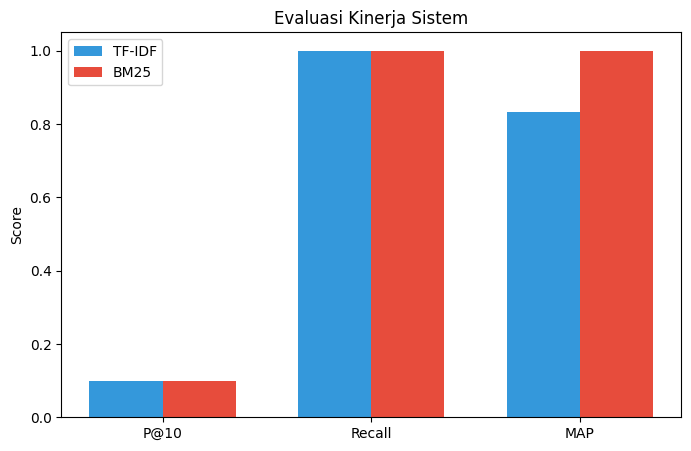

In [8]:
# =====================================================================
# 4. EKSEKUSI EVALUASI (GROUND TRUTH)
# =====================================================================
ground_truth = {
    "sultan dubai aceh bantuan": [0], 
    "bpjs ketenagakerjaan jht": [3],
    "banjir sumatra bencana internasional": [4]
}

eval_results = []
for query, rel_idx in ground_truth.items():
    idx_tfidf, _ = evaluate_search(query, 'tfidf', 10)
    p_t, r_t, ap_t = calculate_metrics(rel_idx, idx_tfidf)
    idx_bm25, _ = evaluate_search(query, 'bm25', 10)
    p_b, r_b, ap_b = calculate_metrics(rel_idx, idx_bm25)
    eval_results.append({
        'Query': query,
        'TF-IDF_P@10': p_t, 'TF-IDF_Recall': r_t, 'TF-IDF_MAP': ap_t,
        'BM25_P@10': p_b, 'BM25_Recall': r_b, 'BM25_MAP': ap_b
    })

df_res = pd.DataFrame(eval_results)
print("\nHasil Evaluasi:")
display(df_res)

# Visualisasi Evaluasi
metrics = ['P@10', 'Recall', 'MAP']
tfidf_scores = [df_res['TF-IDF_P@10'].mean(), df_res['TF-IDF_Recall'].mean(), df_res['TF-IDF_MAP'].mean()]
bm25_scores = [df_res['BM25_P@10'].mean(), df_res['BM25_Recall'].mean(), df_res['BM25_MAP'].mean()]
x = np.arange(len(metrics))
width = 0.35
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, tfidf_scores, width, label='TF-IDF', color='#3498db')
plt.bar(x + width/2, bm25_scores, width, label='BM25', color='#e74c3c')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Evaluasi Kinerja Sistem')
plt.legend()
plt.show()

In [9]:
# =====================================================================
# 5. MENYIMPAN MODEL (SAVE TO FILES)
# =====================================================================
print("\nMenyimpan model ke dalam file...")

# Simpan TF-IDF Vectorizer dan Matrix
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(tfidf_matrix, 'tfidf_matrix.joblib')

# Simpan model BM25 dan data display (menggunakan pickle)
# Kita simpan objek BM25 dan DataFrame asli yang dibutuhkan Streamlit
assets = {
    'bm25_model': bm25,
    'data_display': df[['title', 'body_text', 'url', 'category', 'topics']]
}

with open('hoax_search_assets.pkl', 'wb') as f:
    pickle.dump(assets, f)

print("Selesai! File berikut telah dibuat:")
print("- tfidf_vectorizer.joblib")
print("- tfidf_matrix.joblib")
print("- hoax_search_assets.pkl")


Menyimpan model ke dalam file...
Selesai! File berikut telah dibuat:
- tfidf_vectorizer.joblib
- tfidf_matrix.joblib
- hoax_search_assets.pkl
